In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader,random_split
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
np.random.seed(0)
torch.manual_seed(0)

In [2]:
data = pd.read_csv('pbmc_data.csv')
df = data.iloc[:,1:-2]
X = torch.tensor(df.values).float()
Y = data.iloc[:,-2].values
Y = torch.tensor(Y).long()

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512,hidden_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.ReLU(True),
            nn.Linear(512,1024),
            nn.ReLU(True),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def train(model, train_loader,test_loader, criterion, optimizer, num_epochs,isAE = False):
    training_loss = []
    test_loss = []
    training_acc = []
    test_acc = [] 
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        train_acc = 0
        model.train()
        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (output.argmax(1) == y.argmax(1)).sum().item()
        train_loss /= len(train_loader)
        train_acc /= len(train_loader.dataset)
        training_loss.append(train_loss)
        training_acc.append(train_acc) 
        
        test_acc_value = 0.0
        test_loss_value = 0.0
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                output = model(x)
                loss = criterion(output, y)
                test_loss_value += loss.item()
                test_acc_value += (output.argmax(1) == y.argmax(1)).sum().item()
            test_loss.append(test_loss_value / len(test_loader))
            test_acc.append(test_acc_value / len(test_loader.dataset))
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f}'
              .format(epoch + 1, num_epochs, train_loss, train_acc, test_loss[-1], test_acc[-1]))
        scheduler.step(test_loss_value)
    plt.plot(training_loss)
    plt.plot(test_loss)
    if not isAE:
        plt.plot(training_acc)
    if not isAE:
        plt.plot(test_acc)
    plt.legend(['Training Loss', 'Test Loss', 'Training Accuracy', 'Test Accuracy'])
    plt.show()  # 显示训练损失图
    return model


torch.Size([2638, 1838])


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.8563, Training Accuracy: 0.0004, Test Loss: 0.8276, Test Accuracy: 0.0000
Epoch [2/50], Training Loss: 0.8376, Training Accuracy: 0.0000, Test Loss: 0.8344, Test Accuracy: 0.0000
Epoch [3/50], Training Loss: 0.8342, Training Accuracy: 0.0000, Test Loss: 0.8263, Test Accuracy: 0.0000
Epoch [4/50], Training Loss: 0.8279, Training Accuracy: 0.0004, Test Loss: 0.8264, Test Accuracy: 0.0000
Epoch [5/50], Training Loss: 0.8274, Training Accuracy: 0.0000, Test Loss: 0.8192, Test Accuracy: 0.0000
Epoch [6/50], Training Loss: 0.8272, Training Accuracy: 0.0000, Test Loss: 0.8323, Test Accuracy: 0.0000
Epoch [7/50], Training Loss: 0.8268, Training Accuracy: 0.0000, Test Loss: 0.8226, Test Accuracy: 0.0000
Epoch [8/50], Training Loss: 0.8247, Training Accuracy: 0.0000, Test Loss: 0.8304, Test Accuracy: 0.0000
Epoch [9/50], Training Loss: 0.8242, Training Accuracy: 0.0000, Test Loss: 0.8258, Test Accuracy: 0.0000
Epoch [10/50], Training Loss: 0.8238, Training Accuracy

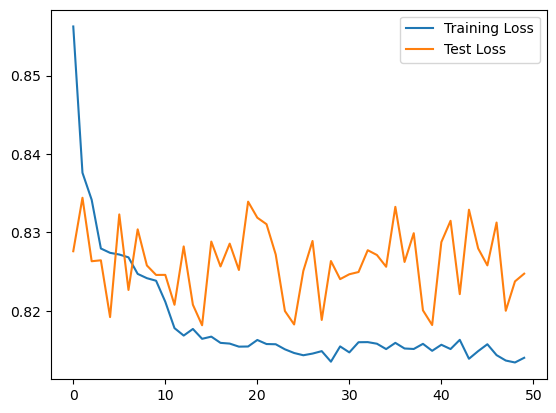

In [7]:
import torch.utils


autoencoder = AutoEncoder(X.shape[1], 2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0005)
dataset = Dataset(X,X)
print(X.shape)
# 确定训练集和测试集的大小
train_size = int(0.9 * len(dataset))  # 80%用于训练
test_size = len(dataset) - train_size  # 剩余20%用于测试

# 随机分割数据集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
autoencoder = train(autoencoder, train_loader,test_loader, criterion, optimizer, 50,isAE=True)

'\nfrom sklearn.decomposition import PCA\nfrom sklearn.manifold import TSNE\nfrom sklearn.preprocessing import StandardScaler\nimport umap\nUMAP = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)\n\nstandardized_df = StandardScaler().fit_transform(XX)\numap_result = UMAP.fit_transform(standardized_df)\nplt.figure(figsize=(7,7))\nplt.title("UMAP plot")\nplt.xlabel("UMAP 1")\nplt.ylabel("UMAP 2")\ncmap = plt.cm.colors.ListedColormap(plt.cm.tab20.colors)\nplt.scatter(umap_result[:,0], umap_result[:,1],c=cmap(Y),s=1)\ndic = {}\n#for i in len(data[\'cell_type\'].iloc[:]):\n#    dic[data[\'cell_type\'][i]] = data[\'cell_type_str\'][i]   \ncell_type_mapping = dict(zip(data[\'cell_type\'], data[\'cell_type_string\']))\n\nlegend_elements = [plt.Line2D([0], [0], marker=\'o\', color=\'w\', label=cell_type_mapping[i],\n                              markerfacecolor=cmap(i), markersize=10) \n                   for i in range(7)]\nplt.legend(handles=legend_elements, title=\'Cell Types\', loc=\

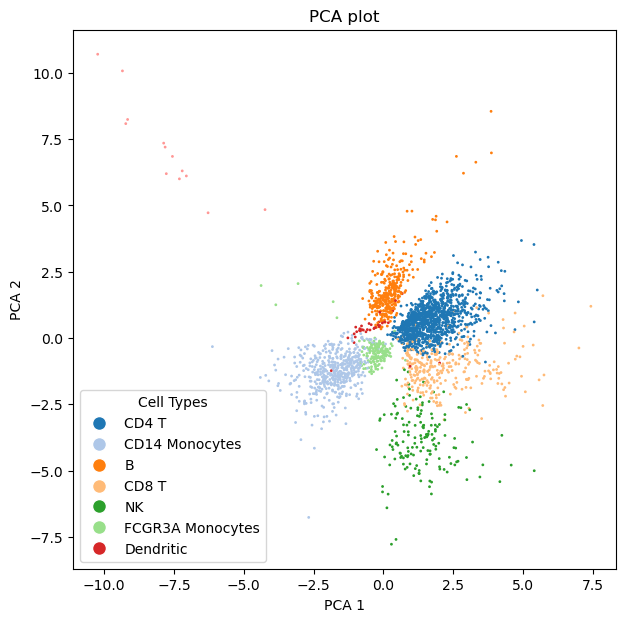

In [ ]:
autoencoder.eval()
XX = autoencoder.cpu().encoder(X).detach().numpy()

plt.figure(figsize=(7,7))
plt.title("PCA plot")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
cmap = plt.cm.colors.ListedColormap(plt.cm.tab20.colors)
plt.scatter(XX[:,0], XX[:,1],c=cmap(Y),s=1)
dic = {}
cell_type_mapping = dict(zip(data['cell_type'], data['cell_type_string']))

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=cell_type_mapping[i],
                              markerfacecolor=cmap(i), markersize=10) 
                   for i in range(7)]
plt.legend(handles=legend_elements, title='Cell Types', loc='best')

In [9]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

torch.Size([2638, 8])


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Training Loss: 1.7936, Training Accuracy: 0.4957, Test Loss: 1.4865, Test Accuracy: 0.8049
Epoch [2/100], Training Loss: 1.1783, Training Accuracy: 0.8479, Test Loss: 0.9871, Test Accuracy: 0.8598
Epoch [3/100], Training Loss: 0.7467, Training Accuracy: 0.8806, Test Loss: 0.6814, Test Accuracy: 0.8883
Epoch [4/100], Training Loss: 0.4985, Training Accuracy: 0.9100, Test Loss: 0.5096, Test Accuracy: 0.9034
Epoch [5/100], Training Loss: 0.3548, Training Accuracy: 0.9436, Test Loss: 0.4066, Test Accuracy: 0.9129
Epoch [6/100], Training Loss: 0.2623, Training Accuracy: 0.9607, Test Loss: 0.3452, Test Accuracy: 0.9356
Epoch [7/100], Training Loss: 0.1989, Training Accuracy: 0.9749, Test Loss: 0.2989, Test Accuracy: 0.9432
Epoch [8/100], Training Loss: 0.1539, Training Accuracy: 0.9853, Test Loss: 0.2639, Test Accuracy: 0.9470
Epoch [9/100], Training Loss: 0.1211, Training Accuracy: 0.9919, Test Loss: 0.2378, Test Accuracy: 0.9508
Epoch [10/100], Training Loss: 0.0964, Trainin

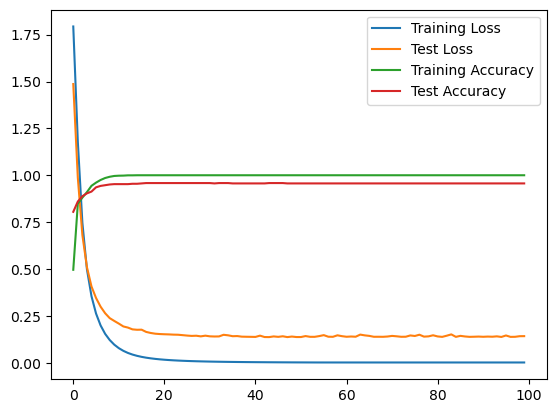

In [10]:
Y = data.iloc[:,-2].values
Y = np.eye(8)[Y]
Y = torch.tensor(Y).float()
print(Y.shape)
classifier = Classifier(X.shape[1], 100,8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
dataset = Dataset(X,Y)
# 确定训练集和测试集的大小
train_size = int(0.8 * len(dataset))  # 80%用于训练
test_size = len(dataset) - train_size  # 剩余20%用于测试

# 随机分割数据集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
classifier = train(classifier, train_loader,test_loader, criterion, optimizer, 100)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.Dropout1d(),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding, bias=False),
            nn.Dropout1d(),
            nn.BatchNorm1d(out_channels),
        )
        
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        self.pool = nn.MaxPool1d(2)
    def forward(self, x):
        out = self.conv(x)
        out += self.shortcut(x)
        out = F.relu(out)
        out = self.pool(out)
        return out

class ResNet1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ResNet1D, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(64, 128, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(128, 256, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(256, 512, num_blocks=2, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.initial_conv(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.global_avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

torch.Size([2638, 8])


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Training Loss: 1.8071, Training Accuracy: 0.3640, Test Loss: 1.7816, Test Accuracy: 0.4413
Epoch [2/100], Training Loss: 1.6322, Training Accuracy: 0.4161, Test Loss: 1.9311, Test Accuracy: 0.4583
Epoch [3/100], Training Loss: 1.5245, Training Accuracy: 0.4408, Test Loss: 1.8564, Test Accuracy: 0.4621
Epoch [4/100], Training Loss: 1.1824, Training Accuracy: 0.5900, Test Loss: 1.2281, Test Accuracy: 0.6723
Epoch [5/100], Training Loss: 0.8113, Training Accuracy: 0.7142, Test Loss: 0.8358, Test Accuracy: 0.7348
Epoch [6/100], Training Loss: 0.6366, Training Accuracy: 0.7697, Test Loss: 0.6554, Test Accuracy: 0.7784
Epoch [7/100], Training Loss: 0.5700, Training Accuracy: 0.7915, Test Loss: 0.6517, Test Accuracy: 0.8030
Epoch [8/100], Training Loss: 0.4985, Training Accuracy: 0.8265, Test Loss: 0.4608, Test Accuracy: 0.8390
Epoch [9/100], Training Loss: 0.4649, Training Accuracy: 0.8365, Test Loss: 0.7323, Test Accuracy: 0.7841
Epoch [10/100], Training Loss: 0.4067, Trainin

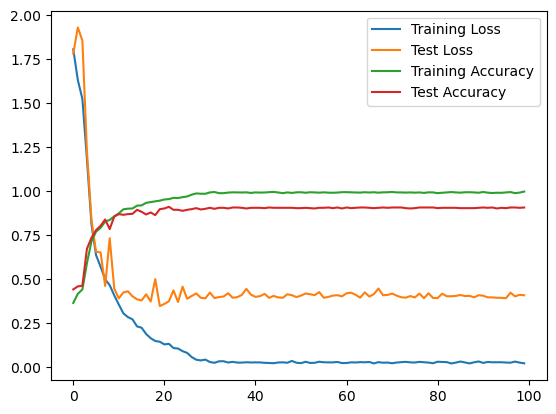

In [12]:
X = torch.tensor(df.values).float()
X = X.unsqueeze(1)
Y = data.iloc[:,-2].values
Y = np.eye(8)[Y]
Y = torch.tensor(Y).float()
print(Y.shape)
classifier = ResNet1D(1, 8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001,weight_decay=1e-4)
dataset = Dataset(X,Y)
# 确定训练集和测试集的大小
train_size = int(0.8 * len(dataset))  # 80%用于训练
test_size = len(dataset) - train_size  # 剩余20%用于测试

# 随机分割数据集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
classifier = train(classifier, train_loader,test_loader, criterion, optimizer, 100)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(LinearResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Linear(in_channels, 2 * in_channels),
            nn.BatchNorm1d(2 * in_channels),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(2 * in_channels, 2 * in_channels),
            nn.BatchNorm1d(2 * in_channels),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(2 * in_channels, out_channels)
        )
        
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Linear(in_channels, out_channels),
            )
    def forward(self, x):
        out = self.conv(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ResNet, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Linear(input_channels, input_channels),
            nn.ReLU()
        )
        self.layer1 = self._make_layer(input_channels,input_channels, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(input_channels,input_channels, num_blocks=2, stride=2)
        self.fc = nn.Linear(input_channels, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(LinearResidualBlock(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))
        for _ in range(1, num_blocks):
            layers.append(LinearResidualBlock(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.initial_conv(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

torch.Size([2638, 8])


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Training Loss: 1.3515, Training Accuracy: 0.7550, Test Loss: 0.2672, Test Accuracy: 0.9205
Epoch [2/100], Training Loss: 0.1851, Training Accuracy: 0.9417, Test Loss: 0.1770, Test Accuracy: 0.9432
Epoch [3/100], Training Loss: 0.0753, Training Accuracy: 0.9782, Test Loss: 0.1590, Test Accuracy: 0.9451
Epoch [4/100], Training Loss: 0.0557, Training Accuracy: 0.9848, Test Loss: 0.2293, Test Accuracy: 0.9432
Epoch [5/100], Training Loss: 0.0369, Training Accuracy: 0.9886, Test Loss: 0.3051, Test Accuracy: 0.9318
Epoch [6/100], Training Loss: 0.0120, Training Accuracy: 0.9948, Test Loss: 0.3514, Test Accuracy: 0.9318
Epoch [7/100], Training Loss: 0.0390, Training Accuracy: 0.9872, Test Loss: 0.2223, Test Accuracy: 0.9451
Epoch [8/100], Training Loss: 0.0289, Training Accuracy: 0.9900, Test Loss: 0.2139, Test Accuracy: 0.9470
Epoch [9/100], Training Loss: 0.0218, Training Accuracy: 0.9891, Test Loss: 0.3445, Test Accuracy: 0.9167
Epoch [10/100], Training Loss: 0.0162, Trainin

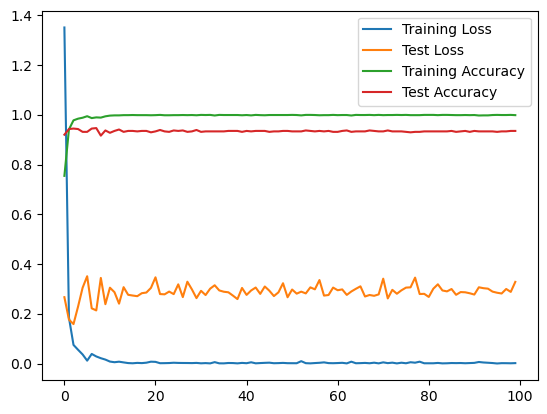

In [14]:
X = torch.tensor(df.values).float()
Y = data.iloc[:,-2].values
Y = np.eye(8)[Y]
Y = torch.tensor(Y).float()
print(Y.shape)
classifier = ResNet(X.shape[1], 8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(classifier.parameters(), lr=0.001)
dataset = Dataset(X,Y)
# 确定训练集和测试集的大小
train_size = int(0.8 * len(dataset))  # 80%用于训练
test_size = len(dataset) - train_size  # 剩余20%用于测试

# 随机分割数据集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
classifier = train(classifier, train_loader,test_loader, criterion, optimizer, 100)

torch.Size([2638, 8])


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Training Loss: 1.7024, Training Accuracy: 0.4213, Test Loss: 1.5622, Test Accuracy: 0.4564
Epoch [2/100], Training Loss: 1.5838, Training Accuracy: 0.4469, Test Loss: 1.4666, Test Accuracy: 0.4564
Epoch [3/100], Training Loss: 1.5028, Training Accuracy: 0.4806, Test Loss: 1.3393, Test Accuracy: 0.5057
Epoch [4/100], Training Loss: 1.4257, Training Accuracy: 0.5261, Test Loss: 1.2887, Test Accuracy: 0.5095
Epoch [5/100], Training Loss: 1.3146, Training Accuracy: 0.5749, Test Loss: 1.2360, Test Accuracy: 0.5189
Epoch [6/100], Training Loss: 1.2173, Training Accuracy: 0.6095, Test Loss: 1.1786, Test Accuracy: 0.5606
Epoch [7/100], Training Loss: 1.1129, Training Accuracy: 0.6573, Test Loss: 1.1304, Test Accuracy: 0.5739
Epoch [8/100], Training Loss: 1.0077, Training Accuracy: 0.6924, Test Loss: 1.1731, Test Accuracy: 0.5814
Epoch [9/100], Training Loss: 0.9271, Training Accuracy: 0.7180, Test Loss: 1.1245, Test Accuracy: 0.6117
Epoch [10/100], Training Loss: 0.8493, Trainin

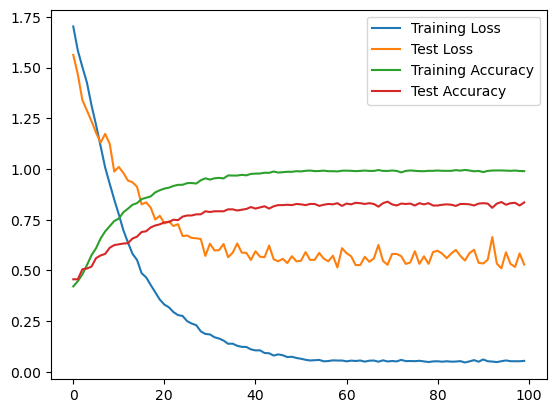

In [15]:
X = torch.tensor(df.values).float()
Y = data.iloc[:,-2].values
Y = np.eye(8)[Y]
Y = torch.tensor(Y).float()
print(Y.shape)
classifier = ResNet(X.shape[1], 8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.001)
dataset = Dataset(X,Y)
# 确定训练集和测试集的大小
train_size = int(0.8 * len(dataset))  # 80%用于训练
test_size = len(dataset) - train_size  # 剩余20%用于测试

# 随机分割数据集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
classifier = train(classifier, train_loader,test_loader, criterion, optimizer, 100)

torch.Size([2638, 8])


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Training Loss: 8.2376, Training Accuracy: 0.6209, Test Loss: 0.6147, Test Accuracy: 0.8011
Epoch [2/100], Training Loss: 0.6869, Training Accuracy: 0.7891, Test Loss: 0.3407, Test Accuracy: 0.8902
Epoch [3/100], Training Loss: 0.3647, Training Accuracy: 0.8896, Test Loss: 0.5037, Test Accuracy: 0.7879
Epoch [4/100], Training Loss: 0.2621, Training Accuracy: 0.9327, Test Loss: 0.7226, Test Accuracy: 0.9280
Epoch [5/100], Training Loss: 0.6400, Training Accuracy: 0.9493, Test Loss: 0.5717, Test Accuracy: 0.9205
Epoch [6/100], Training Loss: 5.1479, Training Accuracy: 0.9436, Test Loss: 2.8875, Test Accuracy: 0.8409
Epoch [7/100], Training Loss: 4.8438, Training Accuracy: 0.9313, Test Loss: 10.7645, Test Accuracy: 0.8731
Epoch [8/100], Training Loss: 1.1058, Training Accuracy: 0.9299, Test Loss: 1.0538, Test Accuracy: 0.7879
Epoch [9/100], Training Loss: 0.2319, Training Accuracy: 0.9597, Test Loss: 0.6169, Test Accuracy: 0.9280
Epoch [10/100], Training Loss: 0.0818, Traini

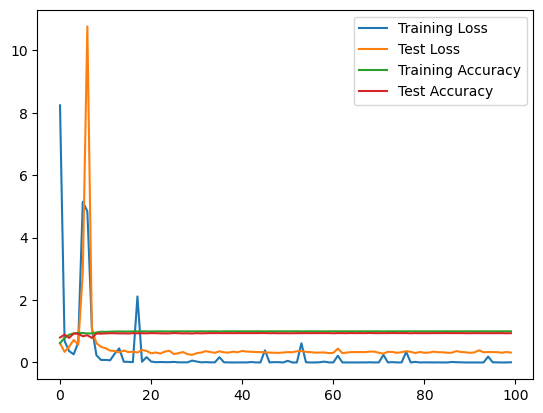

In [18]:
X = torch.tensor(df.values).float()
Y = data.iloc[:,-2].values
Y = np.eye(8)[Y]
Y = torch.tensor(Y).float()
print(Y.shape)
classifier = ResNet(X.shape[1], 8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(classifier.parameters(), lr=0.01)
dataset = Dataset(X,Y)
# 确定训练集和测试集的大小
train_size = int(0.8 * len(dataset))  # 80%用于训练
test_size = len(dataset) - train_size  # 剩余20%用于测试

# 随机分割数据集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
classifier = train(classifier, train_loader,test_loader, criterion, optimizer, 100)


## 神经网络模型评估与比较

在本次实验中，我们构建了多个神经网络模型，通过细胞的基因表达数据预测细胞的类型。我们在网络结构和训练优化器中分别变动了超参数，并对最终的模型进行了评估和比较。以下是详细的评估依据和结论。

### 模型结构与超参数变动

loss function: CrossEntropyLoss

1. **模型1：MLP**
    - 深度：2层Linear层
    - 优化器：AdamW，学习率0.001

2. **模型2：基于卷积的ResNet**
    - 深度：3层Residual Block
    - BatchNorm层：有
    - 优化器：AdamW，学习率0.001

3. **模型3：基于线性层的ResNet**
    - 深度：2层Residual Block
    - BatchNorm层：有
    - 优化器：AdamW，学习率0.001

4. **模型4：不同优化器的ResNet**
    - 优化器：SGD，学习率0.001
    - 其余同模型3

5. **模型5：增加学习率的ResNet**
    - 优化器：AdamW，学习率0.001
    - 其余同模型3

为了提升其在较高lr下的表现，增强其在训练后期的稳定性，使用ReduceLROnPlateau方法做动态学习率调整，当验证集损失不再下降时，将学习率减小为原来的0.1倍。

### 评估依据

1. **训练损失和测试损失**
    - 训练损失和测试损失是衡量模型在训练集和测试集上的表现的重要指标。较低的损失值表示模型在数据上的拟合效果较好。

2. **训练准确率和测试准确率**
    - 准确率是衡量模型分类效果的重要指标。较高的准确率表示模型在预测细胞类型时的效果较好。

3. **收敛速度**
    - 收敛速度是指模型在训练过程中达到稳定状态的速度。较快的收敛速度表示模型在较少的训练轮数内达到了较好的效果。

### 评估结果与结论

1. **模型1：MLP**
    - 最终训练集准确率:1.00
    - 最终测试集准确率:0.9564
    - 收敛速度：20 epoch基本收敛

2. **模型2：基于卷积的ResNet**
    - 最终训练集准确率:0.9976
    - 最终测试集准确率:0.9072
    - 收敛速度：30 epoch基本收敛

3. **模型3：基于线性层的ResNet**
    - 最终训练集准确率:约0.999
    - 最终测试集准确率:0.9356
    - 收敛速度：10 epoch基本收敛

4. **模型4：不同优化器的ResNet**
    - 最终训练集准确率:0.99
    - 最终测试集准确率:0.8352
    - 收敛速度：50 epoch基本收敛

5. **模型5：增加学习率的ResNet**
    - 最终训练集准确率:0.999
    - 最终测试集准确率:0.9413
    - 收敛速度：不够稳定


### 结论
优化器中，AdamW的收敛速度、收敛效果最好，这是因为其采用了动量、自适应学习率等技术，能够更快地收敛到局部最优解。而SGD的收敛速度较慢，可能需要更多的训练轮数才能达到较好的效果。

三种模型相比，MLP效果最优，线性实现的ResNet次之，卷积实现的ResNet效果最差。这可能是由于数据质量较差、数据总量不足等问题导致的。在实际应用中，我们需要根据具体任务的要求选择合适的模型和超参数。

过高的lr可能导致模型在训练后期的不稳定性，因此需要动态调整学习率。在实际应用中，我们需要根据具体任务的要求选择合适的学习率和优化器。

综上所述，通过对不同模型的评估和比较，我们发现基础ResNet模型在训练和测试数据上表现较好，适合用于基因表达数据的分类任务。增加模型的深度和宽度可以提高模型的准确率，但也可能导致过拟合问题。选择合适的优化器可以提高模型的收敛速度和准确率。在实际应用中，我们需要根据具体任务的要求选择合适的模型和超参数。
